In [1]:
%load_ext autoreload
%autoreload 2

import sys,glob,os,errno

import numpy as np
import astropy.units as u 
import matplotlib.pyplot as plt

from gammapy.modeling.models import (
    Models,
    EBLAbsorptionNormSpectralModel,
)
from gammapy.datasets import Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit

In [2]:
basedir     = os.path.abspath("../../../")
datasetdir  = f"{basedir}/LAT/MJD60384/"

In [3]:
# assuming we start from the Notebooks directory
fermi_datasets = Datasets.read(f"{datasetdir}/dataset.yaml")
fermi_datasets.models = list(Models.read(f"{datasetdir}/models.yaml"))

# Our covariance and best-fit parameter file is referenced at 1 GeV
ebl_absorption = EBLAbsorptionNormSpectralModel.read(f"{basedir}/Models/ebl_saldana-lopez_2021.fits.gz",redshift=0.997,alpha_norm=1)
fermi_datasets.models['OP313'].spectral_model *= ebl_absorption

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


In [4]:
# Define a fit
fermi_only_fit    = Fit(store_trace=True)
fermi_only_result = fermi_only_fit.run(fermi_datasets)
# we make a copy here for later comparisons
fermi_only_model = fermi_datasets.models.copy()
# spectral points
energy_edges = np.geomspace(100*u.MeV, 1000*u.GeV, 9)
# Due to EBL, all signal should be concentrated < a few hundred GeV.
energy_edges = energy_edges[energy_edges<500*u.GeV]
fermi_only_fpe = FluxPointsEstimator(energy_edges=energy_edges, source="OP313", selection_optional="all")
fermi_only_points = fermi_only_fpe.run(fermi_datasets).copy()

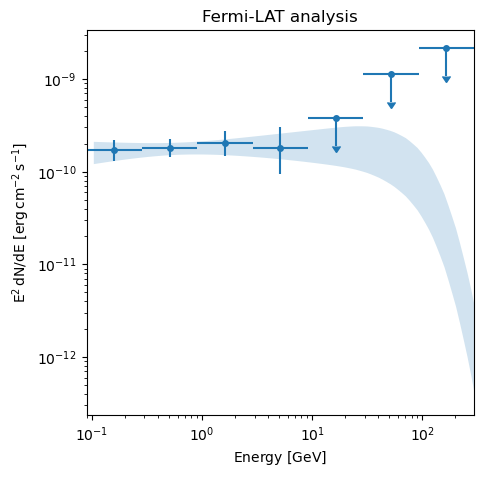

In [5]:
fig = plt.figure(figsize=(5, 5),dpi=100)

ax = fermi_only_model['OP313'].spectral_model.plot_error(
    [energy_edges[0],energy_edges[-1]],
    facecolor='C0',
    sed_type='e2dnde')

fermi_only_points.plot(
    ax=ax, color="C0", sed_type='e2dnde',
)

ax.set_ylabel('$\mathrm{E^2\,dN/dE}$ $\mathrm{[erg\,cm^{-2}\,s^{-1}]}$')
ax.set_title('Fermi-LAT analysis')
!mkdir -p {basedir}/Figures/MJD60384/Fermi-LAT/
fig.savefig(f'{basedir}/Figures/MJD60384/Fermi-LAT/BestFit_Fermi-LAT.pdf',bbox_inches='tight')

In [6]:
fermi_only_model['OP313'].parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str10,float64,str14,float64,float64,float64,bool,bool,str1,str1
,index,1.9553e+00,,1.266e-01,-2.000e+00,8.000e+00,False,False,,
,amplitude,1.1413e-10,MeV-1 s-1 cm-2,1.847e-11,1.000e-13,1.000e-07,False,True,,
,reference,1.0000e+00,GeV,0.000e+00,nan,nan,True,False,,
,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,,
,redshift,9.9700e-01,,0.000e+00,nan,nan,True,False,,
,lon_0,1.9763e+02,deg,0.000e+00,1.976e+02,1.976e+02,True,False,,
,lat_0,3.2355e+01,deg,0.000e+00,3.235e+01,3.235e+01,True,False,,


(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{MeV}$]', ylabel='Residuals (data - model)'>)

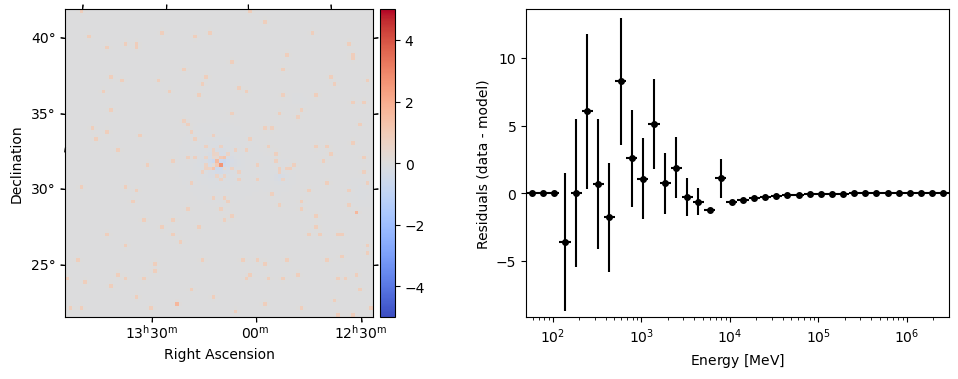

In [7]:
from regions import (
    CircleSkyRegion,
)
fermi_datasets[0].plot_residuals(
    #kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1,smooth_kernel='gauss', smooth_radius='0.5 deg'),
    #kwargs_spectral=dict(region=CircleSkyRegion(fermi_datasets.models['OP313'].spatial_model.position, radius=1 * u.deg)),
)